## Agentnet intro

In this tutorial we build above the [basic tutorial](http://bit.ly/29EvHvZ) withsome new algorithms
* this time we're solving KungFuMaster
* use single-layer LSTM on top of convolutional layers
* actor-critic with n-step critic objective and n-step advantage for actor

In [1]:
#setup theano/lasagne. Prefer GPU
%env THEANO_FLAGS=device=cpu,floatX=float32

env: THEANO_FLAGS=device=cpu,floatX=float32


In [2]:
#If you are running on a server, launch xvfb to record game videos
#Please make sure you have xvfb installed
import os
if os.environ.get("DISPLAY") is str and len(os.environ.get("DISPLAY"))!=0:
    !bash xvfb start
    %env DISPLAY=:1



# Experiment setup
* Here we basically just load the game and check that it works

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#number of parallel agents and batch sequence length (frames)
N_AGENTS = 10
SEQ_LENGTH = 25

[2017-04-07 18:48:04,077] Making new env: SpaceInvaders-v0


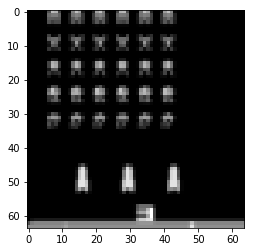

In [4]:
import gym
from agentnet.experiments.openai_gym.wrappers import PreprocessImage
#game maker consider https://gym.openai.com/envs
def make_env():
    env = gym.make("SpaceInvaders-v0")
    return PreprocessImage(env,height=64,width=64,
                           grayscale=True,
                           crop=lambda img:img[50:-10,7:])

#spawn game instance
env = make_env()
observation_shape = env.observation_space.shape
n_actions = env.action_space.n

obs = env.reset()

plt.imshow(obs[0],interpolation='none',cmap='gray')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [5]:
import theano, lasagne
import theano.tensor as T
from lasagne.layers import *

In [6]:
#observation
observation_layer = InputLayer((None,)+observation_shape,)

#4-tick window over images
from agentnet.memory import WindowAugmentation, LSTMCell

prev_wnd = InputLayer((None,4)+observation_shape)
new_wnd = WindowAugmentation(observation_layer,prev_wnd)
        
#reshape to (frame, h,w). If you don't use grayscale, 4 should become 12.
wnd_reshape = reshape(new_wnd, (-1,4*observation_shape[0])+observation_shape[1:])


In [7]:
from lasagne.nonlinearities import elu,tanh,softmax

#network body
conv0 = Conv2DLayer(wnd_reshape,32,5,stride=2,nonlinearity=elu)
conv1 = Conv2DLayer(conv0,32,5,stride=2,nonlinearity=elu)
conv2 = Conv2DLayer(conv1,64,5,stride=2,nonlinearity=elu)
        
dense = DenseLayer(conv2,512,nonlinearity=tanh,name='dense')

In [8]:

prev_cell = InputLayer((None,256))
prev_out = InputLayer((None,256))

new_cell,new_out = LSTMCell(prev_cell,prev_out,dense,name='lstm')

In [9]:
#actor head
logits_layer = DenseLayer(concat([dense,new_out]),n_actions,nonlinearity=None) 
#^^^ store policy logits to regularize them later
policy_layer = NonlinearityLayer(logits_layer,softmax)

#critic head
V_layer = DenseLayer(concat([dense,new_out]),1,nonlinearity=None)

#sample actions proportionally to policy_layer
from agentnet.resolver import ProbabilisticResolver
action_layer = ProbabilisticResolver(policy_layer)



In [10]:
from agentnet.target_network import TargetNetwork
targetnet = TargetNetwork(V_layer)
V_old = targetnet.output_layers

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [11]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(logits_layer,V_layer,V_old),
              agent_states={new_wnd:prev_wnd,new_cell:prev_cell,new_out:prev_out},
              action_layers=action_layer)


In [12]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params([V_layer,policy_layer],trainable=True)
weights

[W,
 b,
 W,
 b,
 W,
 b,
 dense.W,
 dense.b,
 lstm.b_to_ingate,
 lstm.W_ctrl0_to_ingate,
 lstm.W_dense_to_ingate,
 lstm.b_to_forgetgate,
 lstm.W_ctrl0_to_forgetgate,
 lstm.W_dense_to_forgetgate,
 lstm.b_to_cell,
 lstm.W_ctrl0_to_cell,
 lstm.W_dense_to_cell,
 lstm.b_to_outgate,
 lstm.W_ctrl0_to_outgate,
 lstm.W_dense_to_outgate,
 lstm.W_cell_to_ingate_peephole.scales,
 lstm.W_cell_to_forgetgate_peephole.scales,
 lstm.W_cell_to_outgate_peephole.scales,
 W,
 b,
 W,
 b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [13]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,make_env, N_AGENTS) #may need to adjust


[2017-04-07 18:48:47,325] Making new env: SpaceInvaders-v0
[2017-04-07 18:48:47,352] Making new env: SpaceInvaders-v0
[2017-04-07 18:48:47,379] Making new env: SpaceInvaders-v0
[2017-04-07 18:48:47,406] Making new env: SpaceInvaders-v0
[2017-04-07 18:48:47,433] Making new env: SpaceInvaders-v0
[2017-04-07 18:48:47,460] Making new env: SpaceInvaders-v0
[2017-04-07 18:48:47,487] Making new env: SpaceInvaders-v0
[2017-04-07 18:48:47,513] Making new env: SpaceInvaders-v0
[2017-04-07 18:48:47,540] Making new env: SpaceInvaders-v0
[2017-04-07 18:48:47,567] Making new env: SpaceInvaders-v0


In [14]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(10)

print('actions:')
print(action_log[0])
print("rewards")
print(reward_log[0])

actions:
[4 0 2 5 3 0 3 0 2 4]
rewards
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
CPU times: user 732 ms, sys: 1.65 s, total: 2.38 s
Wall time: 418 ms


In [15]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Advantage actor-critic

* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards, alive indicators, etc.
* Code mostly copied from [here](https://github.com/yandexdataschool/tinyverse/blob/0b359aa6a5a9f666d2fa9eab97669c7930b7acb3/atari.py)

In [16]:
#get agent's Qvalues obtained via experience replay
#we don't unroll scan here and propagate automatic updates
#to speed up compilation at a cost of runtime speed
replay = pool.experience_replay

_,_,_,_,(logits_seq,V_seq,old_V_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
    unroll_scan=False,
)

auto_updates = agent.get_automatic_updates()


In [17]:

# compute pi(a|s) and log(pi(a|s)) manually [use logsoftmax]
# we can't guarantee that theano optimizes logsoftmax automatically since it's still in dev
logits_flat = logits_seq.reshape([-1,logits_seq.shape[-1]])
policy_seq = T.nnet.softmax(logits_flat).reshape(logits_seq.shape)
logpolicy_seq = T.nnet.logsoftmax(logits_flat).reshape(logits_seq.shape)
        
# get policy gradient
from agentnet.learning import a2c
elwise_actor_loss,elwise_critic_loss = a2c.get_elementwise_objective(policy=logpolicy_seq,
                                                                     treat_policy_as_logpolicy=True,
                                                                     state_values=V_seq[:,:,0],
                                                                     actions=replay.actions[0],
                                                                     rewards=replay.rewards/100.,
                                                                     is_alive=replay.is_alive,
                                                                     gamma_or_gammas=0.99,
                                                                     n_steps=None,
                                                                     return_separate=True)
        
# add losses with magic numbers 
# (you can change them more or less harmlessly, this usually just makes learning faster/slower)
# also regularize to prioritize exploration
reg_logits = T.mean(logits_seq**2)
reg_entropy = T.mean(T.sum(policy_seq*logpolicy_seq,axis=-1))
loss = 0.1*elwise_actor_loss.mean() + 0.25*elwise_critic_loss.mean() + 1e-3*reg_entropy + 1e-3*reg_logits

        


In [18]:
# Compute weight updates, clip by norm
grads = T.grad(loss,weights)
grads = lasagne.updates.total_norm_constraint(grads,10)

updates = lasagne.updates.adam(grads, weights,1e-4)

#compile train function
train_step = theano.function([],loss,updates=auto_updates+updates)

# Demo run

In [19]:
untrained_reward = np.mean(pool.evaluate(save_path="./records",
                                         record_video=True))

[2017-04-07 18:52:41,096] Making new env: SpaceInvaders-v0
[2017-04-07 18:52:41,125] Creating monitor directory ./records
[2017-04-07 18:52:41,139] Starting new video recorder writing to /home/rodney/AgentNet/examples/records/openaigym.video.0.19778.video000000.mp4
[2017-04-07 18:52:46,626] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/rodney/AgentNet/examples/records')


Episode finished after 492 timesteps with reward=80.0


In [21]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [22]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {}
loss,reward_per_tick,reward =0,0,0

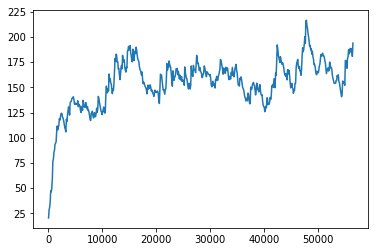

 38%|███▊      | 56410/150000 [65:57:21<111:05:36,  4.27s/it]

iter=56410	loss=0.001	reward/tick=0.218


 38%|███▊      | 56420/150000 [65:58:02<108:48:33,  4.19s/it]

iter=56420	loss=0.000	reward/tick=0.220


 38%|███▊      | 56430/150000 [65:58:45<116:36:52,  4.49s/it]

iter=56430	loss=-0.000	reward/tick=0.215


 38%|███▊      | 56440/150000 [65:59:34<134:28:10,  5.17s/it]

iter=56440	loss=-0.000	reward/tick=0.223


 38%|███▊      | 56448/150000 [66:00:10<118:04:53,  4.54s/it]

In [ ]:
from tqdm import trange
from IPython.display import clear_output

#the algorithm almost converges by 15k iterations, 50k is for full convergence
for i in trange(150000):    
    
    #play
    pool.update(SEQ_LENGTH)

    #train
    loss = 0.95*loss + 0.05*train_step()
    targetnet.load_weights(0.01)
    
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        reward_per_tick = 0.95*reward_per_tick + 0.05*pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tloss=%.3f\treward/tick=%.3f"%(epoch_counter,
                                                      loss,
                                                      reward_per_tick))
        
    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:
        reward = 0.95*reward + 0.05*np.mean(pool.evaluate(record_video=False))
        rewards[epoch_counter] = reward
        
        clear_output(True)
        plt.plot(*zip(*sorted(rewards.items(),key=lambda (t,r):t)))
        plt.show()
        

    
    epoch_counter  +=1

    
# Time to drink some coffee!

# Evaluating results
 * Here we plot learning curves and sample testimonials

In [ ]:
import pandas as pd
plt.plot(*zip(*sorted(rewards.items(),key=lambda k:k[0])))

In [ ]:
from agentnet.utils.persistence import save
save(action_layer,"kung_fu.pcl")

In [ ]:
###LOAD FROM HERE
from agentnet.utils.persistence import load
load(action_layer,"kung_fu.pcl")

In [25]:
rw = pool.evaluate(n_games=20,save_path="./records",record_video=True)
print("mean session score=%f.5"%np.mean(rw))

[2017-03-29 01:21:33,678] Making new env: KungFuMaster-v0
[2017-03-29 01:21:33,717] Clearing 4 monitor files from previous run (because force=True was provided)
[2017-03-29 01:21:33,734] Starting new video recorder writing to /home/justheuristic/agentnet/examples/records/openaigym.video.1.17080.video000000.mp4
[2017-03-29 01:21:49,589] Starting new video recorder writing to /home/justheuristic/agentnet/examples/records/openaigym.video.1.17080.video000001.mp4


Episode finished after 3493 timesteps with reward=25700.0
Episode finished after 4170 timesteps with reward=31900.0
Episode finished after 5181 timesteps with reward=41700.0
Episode finished after 4192 timesteps with reward=30200.0
Episode finished after 3440 timesteps with reward=26100.0
Episode finished after 2991 timesteps with reward=23500.0
Episode finished after 3702 timesteps with reward=29600.0


[2017-03-29 01:23:28,925] Starting new video recorder writing to /home/justheuristic/agentnet/examples/records/openaigym.video.1.17080.video000008.mp4


Episode finished after 3242 timesteps with reward=24000.0
Episode finished after 2358 timesteps with reward=18800.0
Episode finished after 3979 timesteps with reward=29700.0
Episode finished after 5510 timesteps with reward=39800.0
Episode finished after 5083 timesteps with reward=43400.0
Episode finished after 4671 timesteps with reward=42600.0
Episode finished after 2915 timesteps with reward=26100.0
Episode finished after 4510 timesteps with reward=36600.0
Episode finished after 3877 timesteps with reward=36100.0
Episode finished after 4209 timesteps with reward=35700.0
Episode finished after 3996 timesteps with reward=31200.0
Episode finished after 3774 timesteps with reward=29400.0


[2017-03-29 01:26:12,525] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/justheuristic/agentnet/examples/records')


Episode finished after 4939 timesteps with reward=41600.0
mean session score=32185.000000.5


In [27]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

## How to enhance
* More parallel agents
* Different constructs for recurrent memory
* Try PGQ-like algorithms
* Maybe tune parameters for regularization